In [47]:
import pandas as pd
from lib import standardize_item_numbers, standardize_and_drop_rows_w_na_values
import matplotlib.pyplot as plt
import numpy as np

In [48]:
def clean():
    dfa = pd.read_csv("../data/police_reports/electronic_police_report_2018_2022.csv")
    dfa = dfa.pipe(standardize_item_numbers, ["item_number"])

    dfb = pd.read_csv("../data/real_time_crime_center/rtcc.csv")
    dfb["rtcc_requested"] = "yes"
    dfb = dfb.pipe(standardize_item_numbers, ["item_number"])

    df = pd.merge(dfa, dfb, on="item_number", how="outer")
    return df

In [49]:
df = clean()

C:\Users\PC\AppData\Local\Temp\ipykernel_17536\733151713.py:2: DtypeWarning: Columns (14,20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfa = pd.read_csv("../data/police_reports/electronic_police_report_2018_2022.csv")


In [50]:
og_rtcc_df = (df.drop_duplicates(subset=["offender_race", "offender_gender", "offender_age", "item_number"])
        .pipe(standardize_and_drop_rows_w_na_values, ["offender_race"])
)

c:\Users\PC\Desktop\eos\nopd_cameras\notebooks_epr\lib.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = (


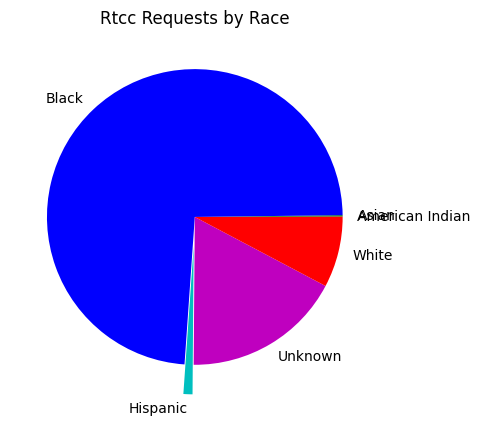

In [51]:
requested_df = og_rtcc_df[((og_rtcc_df.rtcc_requested == "yes"))]


counts = pd.pivot_table(requested_df, index=['offender_race'], values=['rtcc_requested'], aggfunc={'rtcc_requested': np.count_nonzero}).reset_index()

values = counts.rtcc_requested
colors = ['r', 'g', 'b', 'c', 'm']
explode = [0, 0, 0, 0.2, 0, 0]
labels = ['American Indian', 'Asian', 'Black', 'Hispanic', 'Unknown', "White"]
plt.pie(values, colors= colors, labels=labels, explode = explode)
plt.title('Rtcc Requests by Race')
plt.show()

In [52]:
not_requested_df = og_rtcc_df[~((og_rtcc_df.rtcc_requested == "yes"))]
not_requested_df["rtcc_requested"] = "no"

new_rtcc_df = pd.concat([not_requested_df, requested_df])

C:\Users\PC\AppData\Local\Temp\ipykernel_17536\1766426293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_requested_df["rtcc_requested"] = "no"


In [53]:
## review shootings

signal_desc_dict = {"SIMPLE BATTERY": "Simple Battery", "SIMPLE BATTERY (DOMESTIC)": "Simple Battery", "AGGRAVATED BATTERY": "Aggravated Battery", "AGGRAVATED BATTERY (SHOOTING)": "Aggravated Battery"}

signal_desc_clusters = lambda x: signal_desc_dict.get(x, x)

new_rtcc_df.loc[:, "signal_description"] = new_rtcc_df.signal_description.map(signal_desc_clusters)

new_rtcc_df.signal_description.unique()

array(['THEFT', 'AGGRAVATED ASSAULT', 'DRUG LAW VIOLATION', 'DISTURBANCE',
       'SIMPLE CRIMINAL DAMAGE', 'SHOPLIFTING',
       'ILLEGAL CARRYING OF A GUN', 'MISSING/RUNAWAY JUVENILE',
       'SIMPLE BURGLARY (VEHICLE)', 'Simple Battery', 'AGGRAVATED RAPE',
       'MISCELLANEOUS INCIDENT', 'FUGITIVE ATTACHMENT',
       'VIOLATION OF PROTECTIVE ORDERS',
       'SIMPLE CRIMINAL DAMAGE (DOMESTIC)', 'BICYCLE THEFT',
       'Aggravated Battery', 'ELECTRONIC MONITORING', 'CRIMINAL MISCHIEF',
       'AGGRAVATED CRIMINAL DAMAGE', 'AUTO THEFT',
       'SIMPLE BURGLARY (RESIDENCE)', 'SIMPLE BURGLARY (BUSINESS)',
       'UNAUTHORIZED USE OF MOVABLES', 'SIMPLE BURGLARY',
       'DISTURBANCE (FIGHT)', 'DISTURBANCE (DOMESTIC)',
       'THREATS (DOMESTIC)', 'AGGRAVATED ASSAULT (DOMESTIC)',
       'THEFT FROM EXTERIOR OF VEHICLE', 'SIMPLE ASSAULT',
       'ILLEGAL USE OF WEAPONS', 'TRESPASSING', 'SIMPLE KIDNAPPING',
       'ATTEMPTED ARMED ROBBERY (GUN)', 'ATTEMPTED SHOPLIFITING',
       'ATTEMPTED 

In [54]:
top_signal_requests_df = (pd.Series(requested_df.groupby("signal_description")
                                                .rtcc_requested.value_counts()
                                                .sort_values(ascending=False).head(10))
)
top_signal_requests_df = (pd.DataFrame(top_signal_requests_df).unstack()
                                                              .reset_index()
)

top_signal_requests_list = [x for x in top_signal_requests_df["signal_description"]]

top_signal_desc_df = new_rtcc_df[new_rtcc_df.signal_description.isin(top_signal_requests_list)]


top_signal_desc_df = top_signal_desc_df.groupby(["offender_race", "signal_description"]).rtcc_requested.value_counts()
top_signal_desc_df = pd.DataFrame(top_signal_desc_df).sort_values("signal_description")
top_signal_desc_df

rtcc_requested
offender_race signal_description rtcc_requested                
amer. ind.    AGGRAVATED ASSAULT no                           1
hispanic      AGGRAVATED ASSAULT no                          41
asian         AGGRAVATED ASSAULT no                          10
                                 yes                          1
white         AGGRAVATED ASSAULT yes                         24
...                                                         ...
hispanic      SIMPLE ROBBERY     yes                          2
unknown       SIMPLE ROBBERY     yes                         12
                                 no                          36
black         SIMPLE ROBBERY     yes                        231
white         SIMPLE ROBBERY     yes                         10

[72 rows x 1 columns]

In [55]:
# top_signal_desc_df.to_csv("../analysis/excel/rtcc_requests_by_top_10_signal_descriptions.csv")

In [56]:
top_charge_requests_sr = (pd.Series(requested_df.groupby("charge_description")
                                                .rtcc_requested.value_counts()
                                                .sort_values(ascending=False).head(10))
)
top_charge_requests_df = (pd.DataFrame(top_charge_requests_sr).unstack()
                                                              .reset_index()
)

top_charge_requests_list = [x for x in top_charge_requests_df["charge_description"]]

top_charge_desc_df = new_rtcc_df[new_rtcc_df.charge_description.isin(top_charge_requests_list)]


top_charge_desc_df = top_charge_desc_df.groupby(["offender_race", "charge_description"]).rtcc_requested.value_counts()
top_charge_desc_df = pd.DataFrame(top_charge_desc_df).sort_values("charge_description")
top_charge_desc_df

rtcc_requested
offender_race charge_description        rtcc_requested                
amer. ind.    AGG. BATTERY              no                           1
unknown       AGG. BATTERY              no                         210
                                        yes                        114
hispanic      AGG. BATTERY              no                          17
white         AGG. BATTERY              no                          91
...                                                                ...
black         USE OF FIREARM IN ROBBERY yes                        140
                                        no                         257
asian         USE OF FIREARM IN ROBBERY no                           1
unknown       USE OF FIREARM IN ROBBERY yes                          8
white         USE OF FIREARM IN ROBBERY yes                          3

[90 rows x 1 columns]

In [57]:
# top_charge_desc_df.to_csv("../analysis/excel/rtcc_requests_by_top_10_charge_descriptions.csv")